In [1]:
import os
from pathlib import Path
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.io import imread
import cv2
import numpy as np
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
print(os.listdir("/content/drive/MyDrive/Project/Pneumonia-Detection-on-Chest-Xrays/chest_xray"))

['chest_xray', 'test', 'train', 'val', '__MACOSX']


In [4]:
data_dir = Path("/content/drive/MyDrive/Project/Pneumonia-Detection-on-Chest-Xrays/chest_xray/chest_xray")

In [5]:
train_dir = data_dir / 'train'
val_dir = data_dir / 'val'
test_dir = data_dir / 'test'

In [6]:
train_normal_dir = train_dir / 'NORMAL'
train_pneumonia_dir = train_dir / 'PNEUMONIA'

normal_cases = train_normal_dir.glob('*jpeg')
pneumonia_cases = train_pneumonia_dir.glob('*jpeg')

train_data = []
for img in normal_cases:
    train_data.append((img, 0))
for img in pneumonia_cases:
    train_data.append((img, 1))

train_df = pd.DataFrame(train_data, columns = ['Image Path', 'Label'], index = None)
train_df = train_df.sample(frac = 1.).reset_index(drop = True)
train_df.head(10)

,Image Path,Label
0,/content/drive/MyDrive/Project/Pneumonia-Detec...,1
1,/content/drive/MyDrive/Project/Pneumonia-Detec...,1
2,/content/drive/MyDrive/Project/Pneumonia-Detec...,1
3,/content/drive/MyDrive/Project/Pneumonia-Detec...,1
4,/content/drive/MyDrive/Project/Pneumonia-Detec...,0
5,/content/drive/MyDrive/Project/Pneumonia-Detec...,1
6,/content/drive/MyDrive/Project/Pneumonia-Detec...,1
7,/content/drive/MyDrive/Project/Pneumonia-Detec...,0
8,/content/drive/MyDrive/Project/Pneumonia-Detec...,1
9,/content/drive/MyDrive/Project/Pneumonia-Detec...,1


1    3875
0    1341
Name: Label, dtype: int64


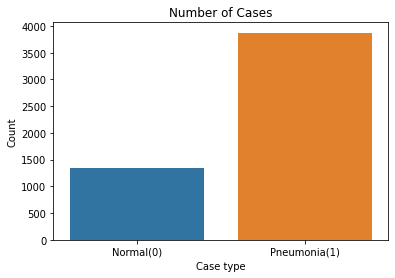

In [7]:
case_count = train_df['Label'].value_counts()
print(case_count)
plt.figure(figsize = (6, 4))
sns.barplot(x = case_count.index, y = case_count.values)
plt.title('Number of Cases')
plt.xlabel('Case type')
plt.ylabel('Count')
plt.xticks(range(len(case_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

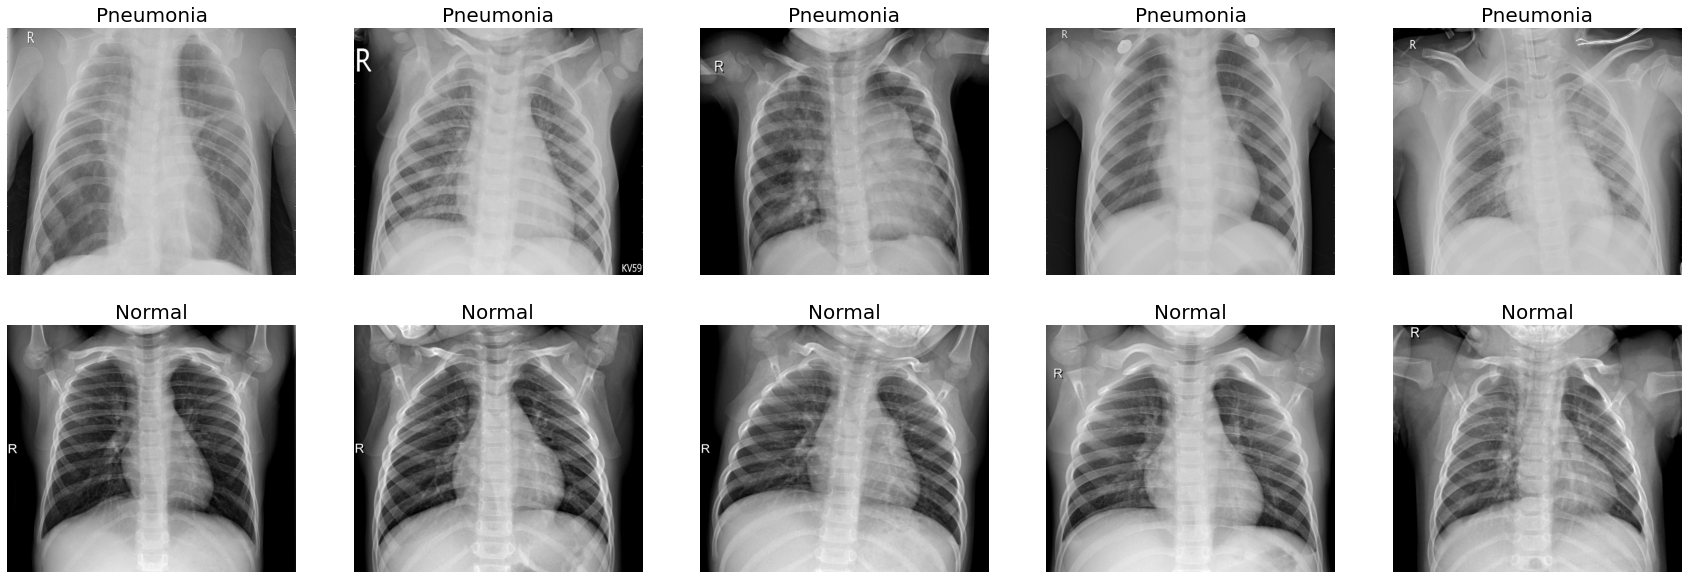

In [8]:
samples_pneumonia = (train_df[train_df['Label'] == 1]['Image Path'].iloc[:5]).tolist()
samples_normal = (train_df[train_df['Label'] == 0]['Image Path'].iloc[:5]).tolist()

total_samples = samples_pneumonia + samples_normal
del samples_pneumonia, samples_normal

f, ax = plt.subplots(2, 5, figsize=(30,10))
for i in range(0, 10):
    img = imread(total_samples[i])
    ax[i // 5, i % 5].imshow(img, cmap='gray')
    if i < 5:
        ax[i // 5, i % 5].set_title("Pneumonia", size=20)
    else:
        ax[i // 5, i % 5].set_title("Normal", size=20)
    ax[i // 5, i % 5].axis('off')
    ax[i // 5, i % 5].set_aspect('auto')

plt.show()

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255.,
                                  rotation_range=20 ,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  brightness_range=[0.6,0.9],
                                  fill_mode='nearest')
test_datagen = ImageDataGenerator( rescale = 1.0/255)

In [10]:
# --------------------
# Flow training images in batches of 32 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    target_size=(300, 300))     
# --------------------
# Flow validation images using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(val_dir,
                                                         shuffle=False,
                                                         class_mode  = 'binary',
                                                         target_size = (300, 300))

# --------------------
# Flow validation images using test_datagen generator
# --------------------
test_generator =  test_datagen.flow_from_directory(test_dir,
                                                         shuffle=False,
                                                         class_mode  = 'binary',
                                                         target_size = (300, 300))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [11]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

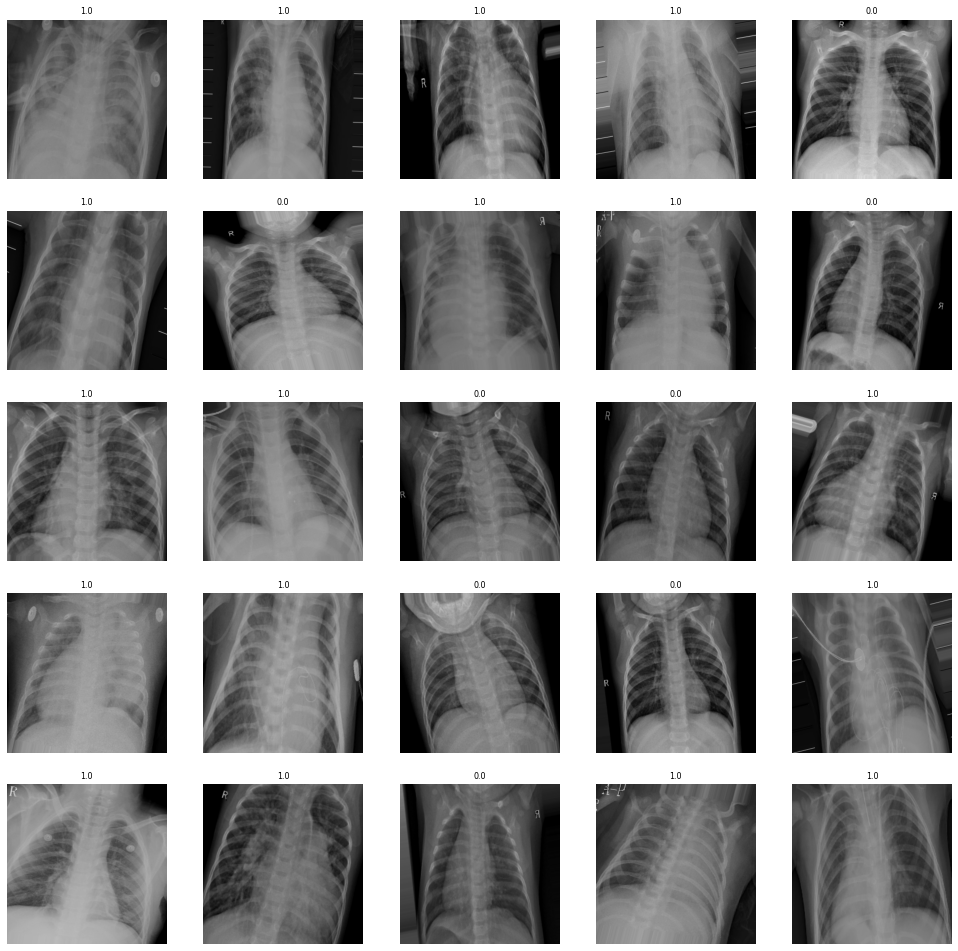

In [12]:
# viualize some images after the augmentation
x_batch, y_batch = next(train_generator)
W = 5
H = 5
fig, axes = plt.subplots(W, H, figsize = (17,17))

axes = axes.ravel() # flaten the matrix into array
for i in np.arange(0, W * H): 

    # Select a random image
    image = x_batch[i]
    # read and display an image with the selected index    
    axes[i].imshow( image )
    axes[i].set_title(y_batch[i], fontsize = 8) # the label
    axes[i].axis('off')

In [13]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

In [14]:
vgg_model = tf.keras.applications.VGG19(
    weights='imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

for layer in vgg_model.layers:
    layer.trainable=False
    
x = vgg_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(inputs=vgg_model.input, outputs=predictions)

# to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=8)

# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

80134624/80134624 [==============================] - 1s 0us/step


In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [16]:
best_model = ModelCheckpoint('.mdl_wts.hdf5', save_best_only = True, monitor = 'val_accuracy')

In [17]:
checkpoint = ModelCheckpoint('model-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5', 
                             verbose=1, 
                             monitor='val_accuracy',
                             save_best_only=True, 
                             mode='max')

In [18]:
history = model.fit(train_generator ,epochs=30, 
                    validation_data=validation_generator,
                     steps_per_epoch=100,
                    callbacks=[checkpoint,early_stopping,lr],
                    batch_size=32)

Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: 0.4282 - accuracy: 0.7916
Epoch 1: val_accuracy improved from -inf to 0.68750, saving model to model-001-0.791562-0.687500.h5
100/100 [==============================] - 654s 6s/step - loss: 0.4282 - accuracy: 0.7916 - val_loss: 0.4788 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 0.3441 - accuracy: 0.8456
Epoch 2: val_accuracy improved from 0.68750 to 0.75000, saving model to model-002-0.845625-0.750000.h5
100/100 [==============================] - 301s 3s/step - loss: 0.3441 - accuracy: 0.8456 - val_loss: 0.5164 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 0.3141 - accuracy: 0.8672
Epoch 3: val_accuracy did not improve from 0.75000
100/100 [==============================] - 186s 2s/step - loss: 0.3141 - accuracy: 0.8672 - val_loss: 0.5074 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 4/30
100/100 [===

In [20]:
# Evaluating the model on train and test
score = model.evaluate(train_generator)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

163/163 [==============================] - 163s 1s/step - loss: 0.1759 - accuracy: 0.9319
Train Loss:  0.17587316036224365
Train Accuracy:  0.9319401979446411


In [21]:
# Test data
score = model.evaluate(test_generator)

print("Test Loss: ", score[0])
print("Test Accuracy: ", score[1])

20/20 [==============================] - 149s 8s/step - loss: 0.3520 - accuracy: 0.8526
Test Loss:  0.3520338833332062
Test Accuracy:  0.8525640964508057


Text(0.5, 1.0, 'Accuracy Evolution')

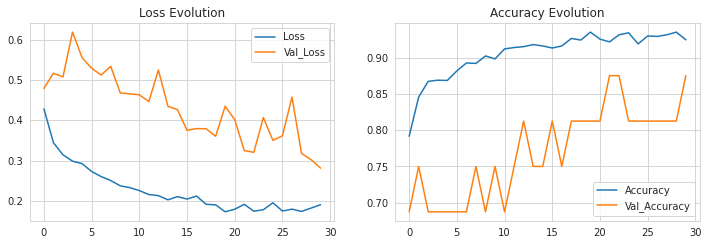

In [22]:
plt.figure(figsize=(12, 8))
plt.title('EVALUATION OF VGG19')

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [23]:
vgg_model.trainable = True

In [24]:
# how many layers are in the base model
print("Number of layers in the base model: ", len(vgg_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in vgg_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  22


In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [26]:
# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [27]:
len(model.trainable_variables)

4

In [28]:
fine_tune_epochs = 10
epochs_on_raw_model = 30

total_epochs =  epochs_on_raw_model + fine_tune_epochs

history_fine =model.fit(train_generator,epochs=total_epochs, 
                    validation_data=validation_generator,
                    steps_per_epoch=100,
                    callbacks=[checkpoint,early_stopping,lr],
                    batch_size=32)

Epoch 1/40
100/100 [==============================] - ETA: 0s - loss: 0.1801 - accuracy: 0.9297
Epoch 1: val_accuracy did not improve from 0.87500
100/100 [==============================] - 102s 1s/step - loss: 0.1801 - accuracy: 0.9297 - val_loss: 0.2856 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 2/40
100/100 [==============================] - ETA: 0s - loss: 0.1720 - accuracy: 0.9309
Epoch 2: val_accuracy did not improve from 0.87500
100/100 [==============================] - 101s 1s/step - loss: 0.1720 - accuracy: 0.9309 - val_loss: 0.3630 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 3/40
100/100 [==============================] - ETA: 0s - loss: 0.1697 - accuracy: 0.9359
Epoch 3: val_accuracy did not improve from 0.87500
100/100 [==============================] - 101s 1s/step - loss: 0.1697 - accuracy: 0.9359 - val_loss: 0.2748 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 4/40
100/100 [==============================] - ETA: 0s - loss: 0.1679 - accuracy: 0.9300
Epoch 4: val_accuracy did no

In [29]:
# Evaluating the model on train and test
score = model.evaluate(train_generator)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model.evaluate(test_generator)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

163/163 [==============================] - 164s 1s/step - loss: 0.1517 - accuracy: 0.9398
Train Loss:  0.15170948207378387
Train Accuracy:  0.9398006200790405
20/20 [==============================] - 7s 299ms/step - loss: 0.3615 - accuracy: 0.8526

Test loss:  0.3615257441997528
Test Accuracy:  0.8525640964508057


Text(0.5, 1.0, 'Accuracy Evolution')

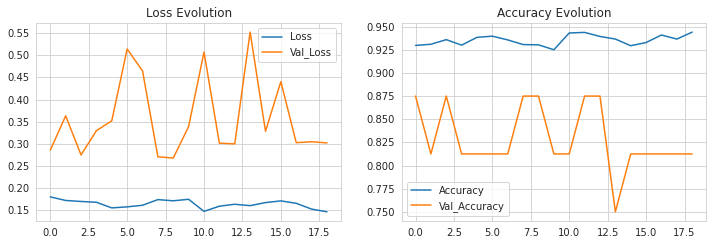

In [30]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history_fine.history['loss'], label='Loss')
plt.plot(history_fine.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history_fine.history['accuracy'], label='Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [35]:
model.save('tuned_VGG19.h5')

In [36]:
final_model = tf.keras.models.load_model('tuned_VGG19.h5')

In [37]:
y_pred = final_model.predict(test_generator)

20/20 [==============================] - 7s 300ms/step


In [38]:
final_model.evaluate(test_generator)

20/20 [==============================] - 7s 301ms/step - loss: 0.3615 - accuracy: 0.8526


[0.3615257441997528, 0.8525640964508057]